# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def reviews_text_to_list(review):
    """
    Convert review field text values into lists
    """
    # result
    result = []

    # cut outer []
    rev_loc = review[1:-1]

    # find comma after ] symbol
    symb_place = rev_loc.find(']')
    reviews_texts = rev_loc[0:symb_place].replace(
        '[', '').replace(']', '').split(',')
    reviews_dates = rev_loc[symb_place +
                            2:].replace('[', '').replace(']', '').split(',')

    for idx, text in enumerate(reviews_texts):
        review_date = None
        if idx < len(reviews_dates):
            review_date = reviews_dates[idx].replace('\'', '').strip()

        if text.strip() != '':
            result.append((text.replace('\'', '').strip(), review_date))

    return result


def date_to_timestamp(str_date, return_timestamp=False):
    """
    Parse date text into date or timestamp.
    """

    if not pd.isnull(str_date):
        if not pd.isnull(str_date[1]):
            try:
                parsed_date = datetime.datetime.strptime(
                    str_date[1], '%m/%d/%Y')  # parse date
            except:
                return None  # return none on error
        else:
            return None  # return None on empty value

        if not pd.isnull(parsed_date):
            if return_timestamp:
                return parsed_date.timestamp()  # return timestamp of the date
            else:
                return parsed_date  # return date
        else:
            return None  # no parsed_date value - return None
    else:
        return None  # no date string value - return None


def calc_percentiles(column):
    """
    Функция расчёта квартилей, иинтерквартильного расстояния и границ выбросов
    """
    # считаем квартили
    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    IQR = perc75 - perc25

    # отображаем границы выбросов
    if IQR > 0:
        print(
            '25-й перцентиль: {},'.format(perc25),
            '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR),
            "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))


def get_cities_populations(_df, _df_cities):
    """
    функция возвращает количество жителей 
    в городах в изначальном наборе данных и возвращает датафрейм с ними
    """
    cities_list = _df.City.unique()

    # находим популиции укзанных городов
    cities_populations = []

    for city in cities_list:
        city_population = 0
        city_rank_min = 0
        city_rank_max = 0

        if len(df_cities[_df_cities.city_ascii == city.strip().lower()]) > 0:
            # remember population
            city_population = _df_cities[_df_cities.city_ascii == city.strip(
            ).lower()].iloc[0]['population']

        # запоминаем минимальное значение места ресторана в городе
        city_rank_min = _df[df.City_clear ==
                            city.strip().lower()].Ranking.min()

        # запоминаем максимальное значение места ресторана в городе
        city_rank_max = _df[df.City_clear ==
                            city.strip().lower()].Ranking.max()

        cities_populations.append(
            (city.strip().lower(), city_population, city_rank_min, city_rank_max))

    return pd.DataFrame(cities_populations, columns=['city', 'population', 'rank_min', 'rank_max'])

## 1. Первичный обзор данных после их загрузки.

In [2]:
df = pd.read_csv('main_task_new.csv')
df_cities = pd.read_csv('worldcities.csv')
df.info()
df.head(10)
# удаляес американские города для уменьшения вроятности выбрать неправильный город
df_cities = df_cities[df_cities.iso3 != 'USA']

# добавляем столбец города с очищенными от начальнлгл и конечного пробелов, 
# а также переведённый в нижний регистр
df['City_clear'] = df.City.apply(lambda x: x.strip().lower())

df_cities.info()
df_cities.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33177 entries, 0 to 41000
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        33177 non-null  object 
 1   city_ascii  33177 non-null

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
5,Shanghai,Shanghai,31.1667,121.4667,China,CN,CHN,Shanghai,admin,22120000.0,1156073548
6,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22046000.0,1076532519
7,Seoul,Seoul,37.5600,126.9900,"Korea, South",KR,KOR,Seoul,primary,21794000.0,1410836482
8,Mexico City,Mexico City,19.4333,-99.1333,Mexico,MX,MEX,Ciudad de México,primary,20996000.0,1484247881
9,Guangzhou,Guangzhou,23.1288,113.2590,China,CN,CHN,Guangdong,admin,20902000.0,1156237133


## 2. Краткий обзор значений столбцов

<AxesSubplot:>

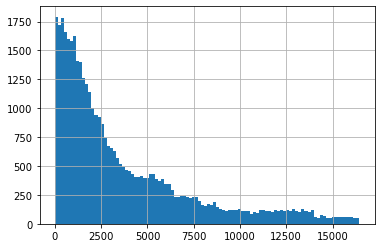

In [3]:
# просматриваем столбцы с данными
# рйтинг
df['Ranking'].hist(bins=100)

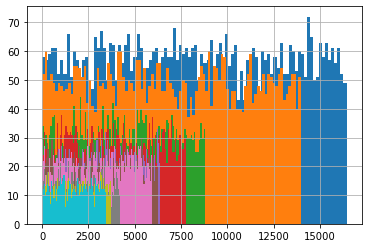

In [4]:
# посмотрим на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

Судя по графикам распределение значений места в городах примерно одинаково

<AxesSubplot:>

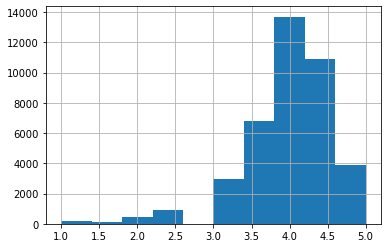

In [5]:
# рейтинг
df['Rating'].hist()

По графику видно, что отсутствуют значения между 2,5 и 3. Значения распределены между 1 и 5. Выбросы отсутствуют (судя по графику)

<AxesSubplot:>

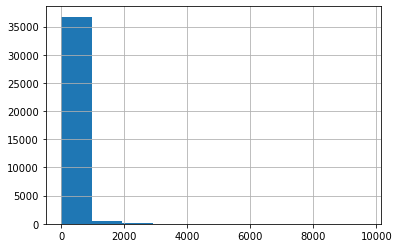

In [6]:
# количество отзывов
df['Number of Reviews'].hist()

In [7]:
# посмотрим на минимальное и максимальное значение столбца
df['Number of Reviews'].min(), df['Number of Reviews'].max()

(2.0, 9660.0)

В столбце, возможно, присутствуют выбросы

In [8]:
calc_percentiles(df['Number of Reviews'])

# просматриваем данные за пределами границ
df[(df['Number of Reviews'] < -162) | (df['Number of Reviews'] > 297)]

25-й перцентиль: 9.0, 75-й перцентиль: 115.0, IQR: 106.0,  Границы выбросов: [-150.0, 274.0].


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,City_clear
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,london
23,id_72,Zurich,"['Asian', 'Thai', 'Vegetarian Friendly', 'Glut...",73.0,4.0,$$ - $$$,371.0,"[['Great Thai Food', 'Great Thai Food In The M...",/Restaurant_Review-g188113-d1018940-Reviews-Wh...,d1018940,zurich
47,id_75,Brussels,"['Belgian', 'European', 'Vegetarian Friendly',...",76.0,4.0,$$ - $$$,484.0,"[['Valentines Dinner', 'Akk Round Very Good'],...",/Restaurant_Review-g188644-d4150215-Reviews-Ch...,d4150215,brussels
54,id_155,Amsterdam,"['Steakhouse', 'Latin', 'Barbecue', 'European'...",156.0,4.5,$$ - $$$,482.0,"[['Perfect foods', 'Everything is hillarious!'...",/Restaurant_Review-g188590-d4588301-Reviews-Vi...,d4588301,amsterdam
58,id_547,Milan,"['Japanese', 'Sushi', 'Vegetarian Friendly']",548.0,4.0,$$ - $$$,554.0,"[['Always a great experience', 'The best sushi...",/Restaurant_Review-g187849-d4353632-Reviews-Ka...,d4353632,milan
...,...,...,...,...,...,...,...,...,...,...,...
39968,id_5553,Milan,"['Italian', 'Wine Bar']",5556.0,3.0,$$ - $$$,507.0,"[['Perfect location but... overpriced', 'The p...",/Restaurant_Review-g187849-d2142329-Reviews-N_...,d2142329,milan
39980,id_253,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",254.0,4.5,$$ - $$$,560.0,[['Creative cocktails and pleasant atmosphere....,/Restaurant_Review-g187791-d8273642-Reviews-Su...,d8273642,rome
39985,id_56,Brussels,"['African', 'Ethiopian', 'Vegetarian Friendly'...",57.0,4.0,$$ - $$$,989.0,"[['A nice experience with Ethiopian food', 'A ...",/Restaurant_Review-g188644-d778285-Reviews-Kok...,d778285,brussels
39992,id_13,Stockholm,"['Swedish', 'Scandinavian', 'Vegetarian Friend...",14.0,4.5,$$ - $$$,1162.0,"[['Great Viking Dinner', 'A foot stompingly go...",/Restaurant_Review-g189852-d2560559-Reviews-Ai...,d2560559,stockholm


По подсчётам в столбце количества отзывов присутствуют выбросы.
Посмотрим на боксплот поля

<AxesSubplot:>

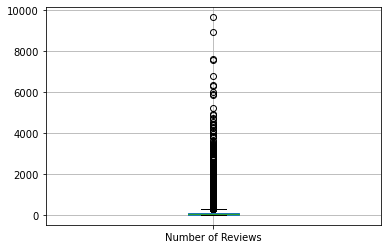

In [9]:
df.boxplot(column=['Number of Reviews'])

В столбце присутствуют выбросы (примерно 4000 значений). Так как их примерно 10 процентов, то их удаление может ухудшить модель. Поэтому все эти значения заменим на среднее значение.

In [10]:
reviews_median = df[(df['Number of Reviews'] < -162) |
                    (df['Number of Reviews'] > 297)].median()
df.loc[(df['Number of Reviews'] < -162) | (df['Number of Reviews']
                                           > 297)]['Number of Reviews'] = reviews_median
df.head(10)

<ipython-input-10-9bdbc16b5ce5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df['Number of Reviews'] < -162) | (df['Number of Reviews']


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,City_clear
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,paris
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,stockholm
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,london
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,berlin
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,munich
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536,oporto
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504,milan
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765,bratislava
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,vienna
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681,rome


<AxesSubplot:>

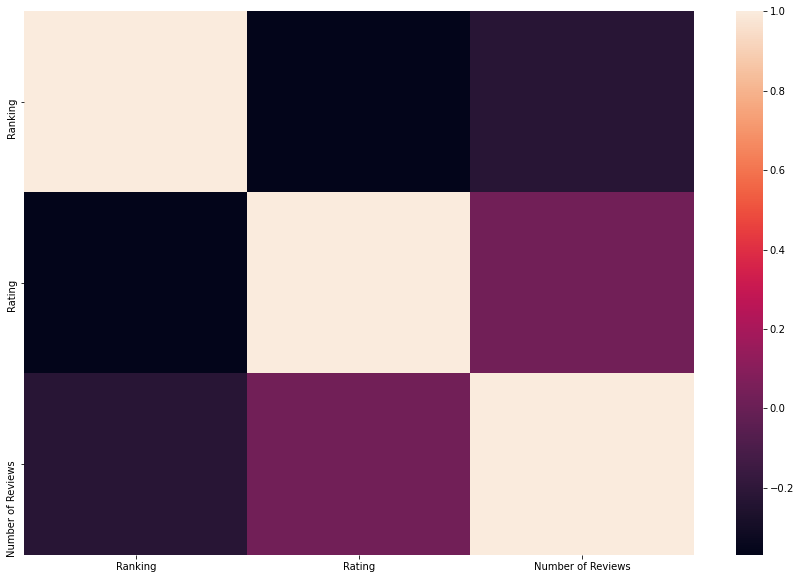

In [12]:
# посмотрим корреляции
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr())

Судя по диаграмме, в изначальном наборе данных отсутствуют сильно зависимые с целевой переменной столбцы, а значит на их основе можно создавать дополнительные столбцы.

In [26]:
# подсчитываем количество ресторанов по городам.
restaurants_counts = df.groupby(['City_clear']).count()

## 3. Обработка других полей и добавление новых


In [14]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки
# Удаляем ненужные символы из списка кухонь

# добавим популяцию городов
df_cities_filter = get_cities_populations(df, df_cities)

df['City population'] = df.City_clear.apply(lambda x:
                                      df_cities_filter[df_cities_filter.city == x].iloc[0][1]
                                      if len(df_cities_filter[df_cities_filter.city == x]) > 0 else 0)

df['Restaurant rank min'] = df.City_clear.apply(lambda x:
                                      df_cities_filter[df_cities_filter.city == x].iloc[0][2]
                                      if len(df_cities_filter[df_cities_filter.city == x]) > 0 else 0)

df['Restaurant rank max'] = df.City_clear.apply(lambda x:
                                      df_cities_filter[df_cities_filter.city == x].iloc[0][3]
                                      if len(df_cities_filter[df_cities_filter.city == x]) > 0 else 0)

df['Restaurants in city'] = df.City_clear.apply(lambda x:
                                                restaurants_counts.loc[x]['Restaurant_id']
                                                if x in restaurants_counts.index else 0)
                                      
                                     

df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: str(x)
                                                .replace('[', '')
                                                .replace(']', '')
                                                .replace('\'', '')
                                                .replace('nan', 'None'))

# превращаем текстовые значения списка кухонь в список
df['Cuisines_list'] = df['Cuisine Style'].apply(
    lambda x: list((str(x).split(','))))

# подсчитываем количество кухонь
df['Cuisines_list_len'] = df['Cuisines_list'].apply(
    lambda x: len(x) if len(x) > 0 else 1)

# подсчитываем количество отзывов
df['Reviews_count'] = df['Reviews'].apply(lambda x: len(
    list(str(x).replace('[', '').replace(']', '').split(','))) / 2)


# превращаем цены в индексы $ - 1, $$ - $$$ - 2, $$$$ - 3, NaN - 2
df['Price Range'] = df['Price Range'].apply(lambda x: 2 if pd.isnull(x) or str(x).strip() == '$$ - $$$' else
                                            1 if str(x).strip() == '$' else 3)

# создаём поле с рейтингом отзыва по содержанию некоторых слов
# чем больше число, тем лучше отзыв. -1 - знаяит отзывы не попали по вышеперечисленным критериям
df['Reviews_rating'] = df['Reviews'].apply(lambda x: 1 if 'poor' in str(x).strip().lower() or
                                           'bad' in str(x).strip().lower() else 2 if
                                           'good' in str(x).strip().lower() or
                                           'like' in str(x).strip().lower() else 3 if
                                           'nice' in str(x).strip().lower() or
                                           'perfect' in str(x).strip().lower() or
                                           'best' in str(x).strip().lower() else -1)

# помечаем строки где отсутствуют значения в столбцах:
#    количество отзывов
df['Number_of_Reviews_isNAN'] = pd.isna(
    df['Number of Reviews']).astype('uint8')

#    кухни
df['Cuisin_Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')

#    ценовая категория
df['Price_Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')


# подсчитываем среднее количество отзывов
mean_numbers_of_reviews = df['Number of Reviews'].mean()
# заполняем пропуски количества отзывов средним значением количества отзывов
df['Number of Reviews'] = df['Number of Reviews'].fillna(
    mean_numbers_of_reviews)

# подсчитываем среднее значение количества кухонь в ресторане
display(df['Cuisines_list_len'].mean())

# конвертируем отзывы в список
df['Reviews_lists'] = df['Reviews'].apply(reviews_text_to_list)

# расширяем список по списку отзывов
df_exploded_review = df.explode('Reviews_lists')

# конвертируем дату в числo
df_exploded_review['review_date_timestamp'] = df_exploded_review['Reviews_lists'].apply(
    lambda x: date_to_timestamp(x, True))
df_exploded_review['review_date'] = df_exploded_review['Reviews_lists'].apply(
    lambda x: date_to_timestamp(x))

# выбираем часто повторяющееся значение даты отзыва
mode_value = df_exploded_review.review_date.mode()[0]

# заполняем пустые значения даты отзыва частоповторяющимся значением
df_exploded_review['review_date'] = df_exploded_review.review_date.fillna(
    mode_value)

# тоже самое выполняем для даты в виде числа
mode_value = df_exploded_review.review_date_timestamp.mode()[0]
df_exploded_review['review_date_timestamp'] = df_exploded_review.review_date_timestamp.fillna(
    mode_value)




display(df.head(10))
df.info()

2.6224

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Restaurant rank max,Restaurants in city,Cuisines_list,Cuisines_list_len,Reviews_count,Reviews_rating,Number_of_Reviews_isNAN,Cuisin_Style_isNAN,Price_Range_isNAN,Reviews_lists
0,id_5569,Paris,"European, French, International",5570.0,3.5,2,194.00000,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,13986.0,4897,"[European, French, International]",3,2.0,2,0,0,0,"[(Good food at your doorstep, 12/31/2017), (A ..."
1,id_1535,Stockholm,None,1537.0,4.0,2,10.00000,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,2464.0,820,[None],1,2.0,-1,0,0,0,"[(Unique cuisine, 07/06/2017), (Delicious Nepa..."
2,id_352,London,"Japanese, Sushi, Asian, Grill, Vegetarian Frie...",353.0,4.5,3,688.00000,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,16444.0,5757,"[Japanese, Sushi, Asian, Grill, Vegetarian...",7,2.0,-1,0,0,0,"[(Catch up with friends, 01/08/2018), (Not exc..."
3,id_3456,Berlin,None,3458.0,5.0,2,3.00000,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,6372.0,2155,[None],1,1.0,-1,0,0,0,[]
4,id_615,Munich,"German, Central European, Vegetarian Friendly",621.0,4.0,2,84.00000,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,2763.0,893,"[German, Central European, Vegetarian Friendly]",3,2.0,3,0,0,0,"[(Best place to try a Bavarian food, 11/18/201..."
5,id_1418,Oporto,None,1419.0,3.0,2,2.00000,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536,...,1484.0,513,[None],1,2.5,2,0,0,0,"[(There are better 3 star hotel bars, 09/16/20..."
6,id_1720,Milan,"Italian, Pizza",1722.0,4.0,1,50.00000,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504,...,6275.0,2133,"[Italian, Pizza]",2,2.0,-1,0,0,0,"[(Excellent simple local eatery., 08/04/2017),..."
7,id_825,Bratislava,Italian,826.0,3.0,2,9.00000,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765,...,889.0,301,[Italian],1,2.0,-1,0,0,0,"[(Wasting of money, 02/16/2014), (excellent cu..."
8,id_2690,Vienna,None,2692.0,4.0,2,124.82548,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,...,3444.0,1166,[None],1,1.0,-1,1,0,0,[]
9,id_4209,Rome,"Italian, Pizza, Fast Food",4210.0,4.0,1,55.00000,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681,...,5946.0,2078,"[Italian, Pizza, Fast Food]",3,2.0,3,0,0,0,"[(Clean efficient staff, 11/07/2017), (Nice li..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            40000 non-null  object 
 1   City                     40000 non-null  object 
 2   Cuisine Style            40000 non-null  object 
 3   Ranking                  40000 non-null  float64
 4   Rating                   40000 non-null  float64
 5   Price Range              40000 non-null  int64  
 6   Number of Reviews        40000 non-null  float64
 7   Reviews                  40000 non-null  object 
 8   URL_TA                   40000 non-null  object 
 9   ID_TA                    40000 non-null  object 
 10  City_clear               40000 non-null  object 
 11  City population          40000 non-null  int64  
 12  Restaurant rank min      40000 non-null  float64
 13  Restaurant rank max      40000 non-null  float64
 14  Restaurants in city   

<AxesSubplot:>

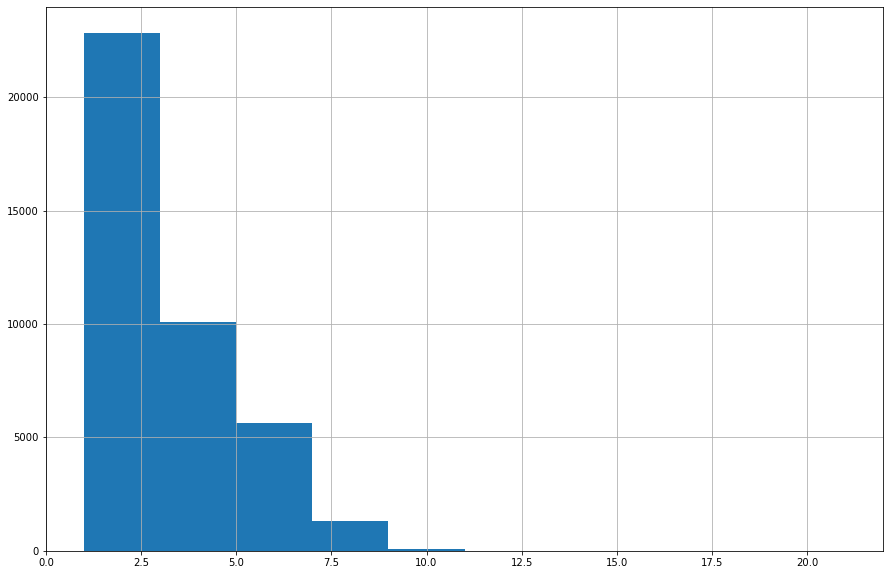

In [15]:
# Дополнительно анализируем столбец количества кухонь
df['Cuisines_list_len'].hist()

25-й перцентиль: 1.0, 75-й перцентиль: 4.0, IQR: 3.0,  Границы выбросов: [-3.5, 8.5].


<AxesSubplot:>

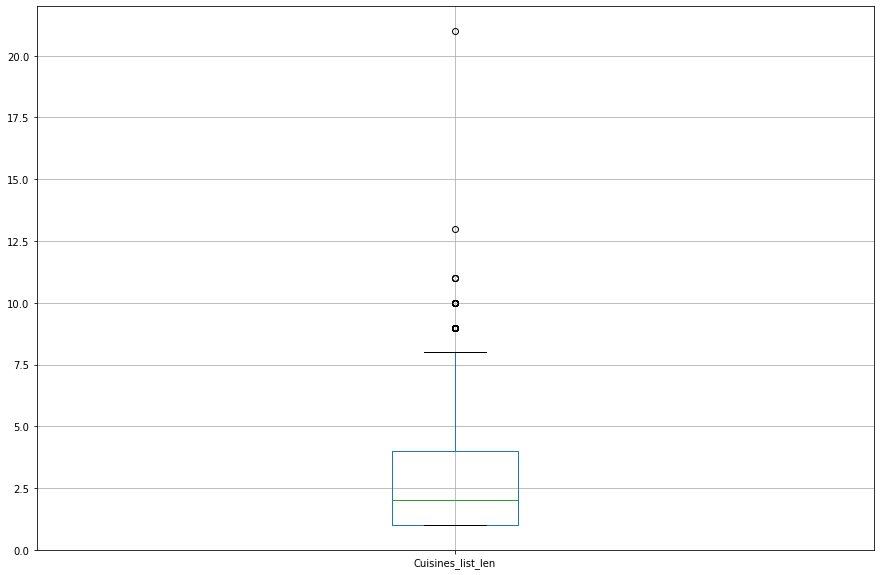

In [16]:
# считаем квартили и ищем выбросы
calc_percentiles(df['Cuisines_list_len'])

# просматриваем боксплот
df.boxplot(column=['Cuisines_list_len'])

# просматриваем данные за пределами границ
# df[(df['Cuisines_list_len'] < -3.5) | (df['Cuisines_list_len'] > 8.5)]

In [17]:
# в столбце присутствуют выбросы (100 значений). Заменим их на средние значение
cuisines_len_median = df[(df['Cuisines_list_len'] < -3.5)
                          | (df['Cuisines_list_len'] > 8.5)].median()
df.loc[(df['Cuisines_list_len'] < -3.5) | (df['Cuisines_list_len']
                                           > 8.5)]['Cuisines_list_len'] = cuisines_len_median
df.head()

<ipython-input-17-08587ae1a99a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df['Cuisines_list_len'] < -3.5) | (df['Cuisines_list_len']


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Restaurant rank max,Restaurants in city,Cuisines_list,Cuisines_list_len,Reviews_count,Reviews_rating,Number_of_Reviews_isNAN,Cuisin_Style_isNAN,Price_Range_isNAN,Reviews_lists
0,id_5569,Paris,"European, French, International",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,13986.0,4897,"[European, French, International]",3,2.0,2,0,0,0,"[(Good food at your doorstep, 12/31/2017), (A ..."
1,id_1535,Stockholm,None,1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,2464.0,820,[None],1,2.0,-1,0,0,0,"[(Unique cuisine, 07/06/2017), (Delicious Nepa..."
2,id_352,London,"Japanese, Sushi, Asian, Grill, Vegetarian Frie...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,16444.0,5757,"[Japanese, Sushi, Asian, Grill, Vegetarian...",7,2.0,-1,0,0,0,"[(Catch up with friends, 01/08/2018), (Not exc..."
3,id_3456,Berlin,None,3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,6372.0,2155,[None],1,1.0,-1,0,0,0,[]
4,id_615,Munich,"German, Central European, Vegetarian Friendly",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,2763.0,893,"[German, Central European, Vegetarian Friendly]",3,2.0,3,0,0,0,"[(Best place to try a Bavarian food, 11/18/201..."


In [18]:
# очищаем данные в списках кухонь от пустых значений
df_copy = df.copy()
df_copy['Cuisine Style'] = df_copy['Cuisine Style'].dropna()


# собираем список уникальных значений кухонь
cuisines = []

for df_cuisine in df_copy['Cuisines_list']:
    for cuisine in df_cuisine:
        if cuisine != 'None':
            cuisines.append(cuisine.strip())

display(len(list(set(cuisines))))

# расширяем список по значениям кухонь
df_exploded = df.explode('Cuisines_list')
# df = df_exploded

display(df_exploded['Cuisines_list'].value_counts())

125

 Vegetarian Friendly    10892
None                     9283
 European                7932
Italian                  5532
 Vegan Options           4473
                        ...  
Armenian                    1
 Salvadoran                 1
 Latvian                    1
Singaporean                 1
Uzbek                       1
Name: Cuisines_list, Length: 233, dtype: int64

In [19]:
# заполняем пустые значения кухонь вегетарианской как самая частоповторяющаяся
df['Cuisine Style'].fillna("['Vegetarian Friendly']", inplace=True)

# превращаем значения столбца кухонь в числовые столбцы
# очистка от ненужных символов
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: str(x)[1:-1])
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace("'", ""))
cuisines = df['Cuisine Style'].str.get_dummies(sep=',').add_prefix('Cuisine_')
df = df.join(cuisines)

# превращаем значения столбцов город и ценовая категория в столбцы
df = pd.get_dummies(df, columns=['Price Range', 'City'])  # price range

df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 478 entries, Restaurant_id to City_Zurich
dtypes: float64(6), int64(427), object(8), uint8(37)
memory usage: 136.0+ MB


## 4. Проверка производительности модели.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [20]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = None
object_columns = [s for s in df.columns if df[s].dtypes ==
                  'object' or df[s].dtype == 'datetime64']
object_columns.append('Rating')
X = df.drop(object_columns, axis=1)

y = df['Rating']
X

,Ranking,Number of Reviews,City population,Restaurant rank min,Restaurant rank max,Restaurants in city,Cuisines_list_len,Reviews_count,Reviews_rating,Number_of_Reviews_isNAN,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,5570.0,194.0,0,3.0,13986.0,4897,3,2.0,2,0,...,0,0,0,1,0,0,0,0,0,0
1,1537.0,10.0,0,1.0,2464.0,820,1,2.0,-1,0,...,0,0,0,0,0,0,1,0,0,0
2,353.0,688.0,0,1.0,16444.0,5757,7,2.0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,3458.0,3.0,0,2.0,6372.0,2155,1,1.0,-1,0,...,0,0,0,0,0,0,0,0,0,0
4,621.0,84.0,0,3.0,2763.0,893,3,2.0,3,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,79.0,0,1.0,6275.0,2133,4,2.5,-1,0,...,0,0,0,0,0,0,0,0,0,0
39996,6341.0,542.0,0,3.0,13986.0,4897,5,2.0,2,0,...,0,0,0,1,0,0,0,0,0,0
39997,1652.0,4.0,0,1.0,2464.0,820,2,2.0,2,0,...,0,0,0,0,0,0,1,0,0,0
39998,641.0,70.0,0,1.0,2141.0,727,5,2.0,-1,0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [22]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [23]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [24]:
# Создаём модель
RANDOM_SEED = 65
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [25]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20829650000000002
